In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

In [3]:
import time
import emcee
import numpy as np
import pymc3 as pm

import theano
import theano.tensor as tt

import exoplanet as xo

target_n_eff = 500

np.random.seed(1234)

N_pl = 1
periods = np.exp(np.random.uniform(np.log(1), np.log(100), size=N_pl))
t0s = periods * np.random.rand(N_pl)
Ks = np.sort(np.exp(np.random.uniform(np.log(2), np.log(10), N_pl)))[::-1]
eccs = np.random.uniform(0, 0.1, N_pl)
omegas = np.random.uniform(-np.pi, np.pi, N_pl)

N = 25 + 25 * N_pl
x = np.sort(np.random.uniform(-2*365, 2*365, N))
yerr = np.random.uniform(0.5, 5.0, N)

t = np.linspace(x.min()-5, x.max()+5, 1000)

In [4]:
with pm.Model() as model:

    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=10.0, shape=N_pl)
    logP = pm.Normal("logP", mu=np.log(periods), sd=1.0, shape=N_pl)
    P = pm.Deterministic("P", tt.exp(logP))

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal("logK", mu=np.log(Ks), sd=10.0, shape=N_pl)

    # This is a sanity check that restricts the semiamplitude to reasonable
    # values because things can get ugly as K -> 0
    pm.Potential("logK_bound", tt.switch(logK < -2., -np.inf, 0.0))
    
    # The amlitudes should be sorted
    pm.Potential("logK_order", tt.switch(logK[1:] > logK[:-1], -np.inf, 0.0))

    # We also want to keep period physical but this probably won't be hit
    pm.Potential("P_bound", tt.switch(P <= 0, -np.inf, 0.0))

    # Eccentricity & argument of periasteron
    ecc = pm.Uniform("ecc", lower=0, upper=0.99, shape=N_pl,
                     testval=eccs)
    omega = xo.distributions.Angle("omega", shape=N_pl, testval=omegas)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)
    
    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)

    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    if N_pl == 1:
        vrad = vrad[:, None]
    pm.Deterministic("vrad", vrad)

    # Define the background model
    A = np.vander(x - 0.5*(x.min() + x.max()), 3)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))

    # Sum over planets and add the background to get the full model
    rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)

    # Simulate the data
    y_true = xo.eval_in_model(rv_model)
    y = y_true + yerr * np.random.randn(len(yerr))
    
    # Compute the prediction
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    if N_pl == 1:
        vrad_pred = vrad_pred[:, None]
    pm.Deterministic("vrad_pred", vrad_pred)
    A_pred = np.vander(t - 0.5*(x.min() + x.max()), 3)
    bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    rv_model_pred = pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)
    
    # Likelihood
    err = tt.sqrt(yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

    # Optimize
    map_soln = pm.find_MAP(start=model.test_point, vars=[trend])
    map_soln = pm.find_MAP(start=map_soln)

logp = -130.68, ||grad|| = 40.279: 100%|██████████| 27/27 [00:00<00:00, 1163.89it/s]  
logp = -122.78, ||grad|| = 1.1251e+05: 100%|██████████| 47/47 [00:00<00:00, 833.73it/s]  


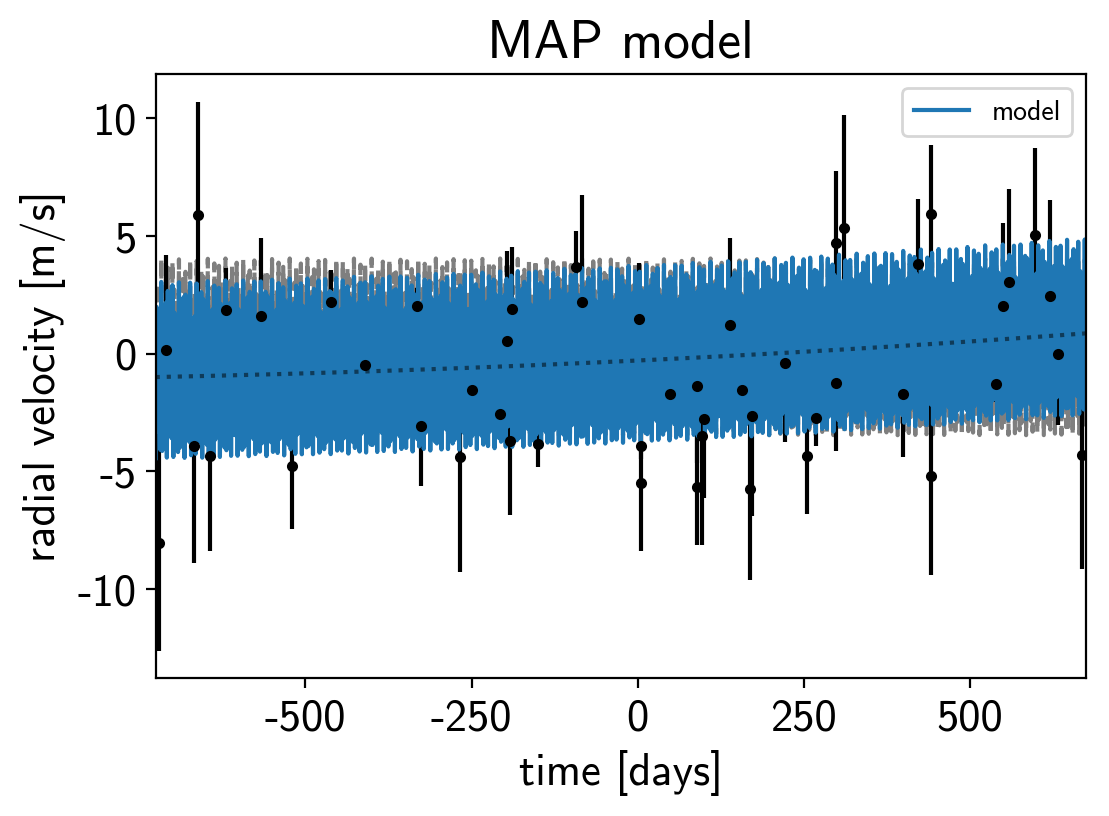

In [5]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("MAP model");

In [6]:
def check_convergence(samples):
    tau = emcee.autocorr.integrated_time(samples, tol=0)
    num = samples.shape[0] * samples.shape[1]
    print(num / tau)
    converged = np.all(tau * target_n_eff < num)
    converged &= np.all(len(samples) > 50 * tau)
    return converged, num / tau

In [7]:
sampler = xo.PyMC3Sampler(finish=200, window=200)
with model:
    burnin = sampler.tune(tune=5000, start=map_soln)

Sampling 2 chains: 100%|██████████| 404/404 [00:02<00:00, 195.73draws/s]


In [8]:
chains = 2
tottime = 0
trace = None
with model:
    while True:
        strt = time.time()
        trace = sampler.sample(draws=2000, trace=trace, chains=chains, cores=1)
        tottime += time.time() - strt
        
        samples = np.array(trace.get_values("P", combine=False))
        samples = np.moveaxis(samples, 0, 1)
        flag, n_eff = check_convergence(samples)
        if flag:
            break

    time_pymc = tottime
    time_ind_pymc = tottime / n_eff
    n_eff_pymc = n_eff

Sequential sampling (2 chains in 1 job)
NUTS: [trend, logs, omega, ecc, logK, logP, t0]
100%|██████████| 2000/2000 [00:15<00:00, 126.73it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9057182681949839, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9010528438859706, but should be close to 0.8. Try to increase the number of tuning steps.


[2500.8720279]


In [9]:
time_ind_pymc

array([0.01280642])

In [10]:
import string

for n, letter in enumerate(string.ascii_lowercase[1:N_pl+1]):
    fig = plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    if N_pl > 1:
        inds = np.arange(N_pl) != n
        other = np.median(np.sum(trace["vrad"][:, :, inds], axis=-1), axis=0)
    else:
        other = np.zeros_like(y)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
    art.set_edgecolor("none")
    
    plt.annotate("period = {0:.4f} +/- {1:.4f} d".format(p, np.std(trace["P"][:, n])),
                 (0, 1), xycoords="axes fraction",
                 xytext=(5, -5), textcoords="offset points",
                 va="top", ha="left", fontsize=12)

    plt.annotate("true period = {0:.4f} d".format(periods[n]),
                 (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 va="bottom", ha="left", fontsize=12)
    
    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    
    fig.savefig("phase-{0}.pdf".format(letter))
    plt.close(fig)

In [11]:
# Fit using emcee
with model:
    # Loop over samples and convert to the relevant parameter space;
    # I'm sure that there's an easier way to do this, but I don't know
    # how to make something work in general...
    N = len(trace) * trace.nchains
    samples = np.empty((N, model.ndim))
    i = 0
    for chain in trace._straces.values():
        for p in chain:
            samples[i] = model.bijection.map(p)
            i += 1
    
    # Build a wrapper around the theano model
    f = theano.function(model.vars,
                        [model.logpt] + model.vars + model.deterministics)

    def log_prob_func(params):
        dct = model.bijection.rmap(params)
        args = (dct[k.name] for k in model.vars)
        results = f(*args)
        return tuple(results)

    # First we work out the shapes of all of the deterministic variables
    res = model.test_point
    vec = model.bijection.map(res)
    initial_blobs = log_prob_func(vec)[1:]
    dtype = [(var.name, float, np.shape(b)) for var, b in
             zip(model.vars + model.deterministics, initial_blobs)]

    # Then sample as usual
    coords = samples[np.random.randint(len(samples), size=2*samples.shape[1])]  # vec + 1e-5 * np.random.randn(3*len(vec), len(vec))
    nwalkers, ndim = coords.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_func,
                                    blobs_dtype=dtype)
    thin_by = 10
    tottime = 0
    for i in range(1000):
        strt = time.time()
        sampler.run_mcmc(coords, 500, thin_by=thin_by, progress=True)
        tottime += time.time() - strt

        samples = sampler.get_blobs()["P"]
        flag, n_eff = check_convergence(samples)
        if flag:
            break
    
    time_emcee = tottime
    time_ind_emcee = tottime / n_eff
    n_eff_emcee = n_eff

100%|██████████| 5000/5000 [00:34<00:00, 144.05it/s]


[813.74816376]


100%|██████████| 5000/5000 [00:34<00:00, 146.60it/s]

[1413.56654611]


In [12]:
model.ndim

10

In [13]:
len(vec)

10

In [17]:
df = pm.trace_to_dataframe(trace)

In [24]:
blobs = sampler.get_blobs(flat=True)

In [28]:
import h5py
with h5py.File("blah.h5", "w") as f:
    f.create_dataset("blobs", data=blobs)

In [25]:
import pandas as pd

In [26]:
df2 = pd.DataFrame.from_records(blobs)

Exception: Data must be 1-dimensional

In [27]:
blobs.shape

(20000,)